In [1]:
# general packages and libraries
import os
import sys
from collections import defaultdict
import importlib

In [2]:
# data manipulation packages
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
# data visualizations packages
import matplotlib.pyplot as plt
# to render plots in the notebook
%matplotlib inline

import seaborn as sns
# set a theme for seaborn
sns.set_theme()

In [54]:
# numerical, statistical and machine learning packages and libraries
import xgboost as xgb

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from sklearn.base import (
    BaseEstimator, 
    TransformerMixin,
)
from sklearn.pipeline import (
    make_pipeline,
    Pipeline,
    FeatureUnion,
)
from sklearn.feature_selection import (
    SelectKBest, 
    mutual_info_classif,
)
from sklearn.impute import (
    KNNImputer,
    SimpleImputer,
)
from sklearn.preprocessing import (
    OrdinalEncoder, 
    StandardScaler,
    MultiLabelBinarizer,
)
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    RandomizedSearchCV
)

from sklearn.linear_model import (
    SGDClassifier,
    LogisticRegression,
) 

from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
)
    
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    auc,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score
)

In [5]:
# create a string for the working directory
mypath = '/home/silvia/Documents/udacityND/ml_dsnd/proj1_dsnd/'

# add src folder to sys.path to use the local modules
sys.path.insert(1, mypath + 'src')

In [6]:
# import local modules 
import utils_functions as uf 
import utils_classes as uc
import local_maps as lm                                                                 

In [7]:
# re-load the modules
importlib.reload(uf);
importlib.reload(uc);
importlib.reload(lm);

# Analysis of StackOverflow Survey. Part IV

We build a model to predict job satisfaction for data coders. The steps of the process are as follows:

- Formulate the problem to address.
- Gather and prepare the data.
- Remove unnecessary data.
- Pre-process data from several columns.
- Sample data.
- Impute the missing values.
- Encode the predictors according to dtype.
- Evaluate several algorithms.
- Tune the best algorithm.
- Draw model insights with SHAP.

## Predict Job Satisfaction for 2020 StackOverflow Developers Survey

We separate the respondents of the 2020 StackOverflow Developer Survey into data coders (data scientist or machine learning specialist, data or business analyst, data engineer) and other coders. In what follows we restrict the dataset to the data coders and address the following questions:

What can we tell about the job satisfaction of a data developer?
What factors do influence the job satisfaction?

We build a predictive model for the job satisfaction for data developers. This is a multi-class classification question, where the satisfaction levels are: 

>very dissatisfied - 1  
>slightly dissatisfied - 2  
>neither satisfied nor dissatisfied - 3   
>slightly satisfied - 4  
>very satisfied - 5.

## Performance metrics - to review at the end

We print out the confusion matrix, and calculate accuracy, precision, recall and F1-score, using macro method of averaging over the individual labels scores. 

## Load the data

Upload the data and keep the subset that contains those developers that work in data science related fields.

In [9]:
# upload the datafile as pandas dataframe
df = pd.read_csv(mypath+'data/interim/survey20_updated.csv', index_col=[0])
# check for success
df.shape

(64461, 61)

## Remove unnecessary data

In [10]:
# create a copy of the data
df1 = df.copy()

### Retain only the developers that work with data 

In [11]:
# parse each list of strings entry 
df1['DevType'] = df1['DevType'].str.split(';')

# transform each element of a list-like to a row, replicating index values
df1 = df1.explode('DevType')

# check the outcome
df1.shape

(172185, 61)

In [12]:
# retain only those rows that contain data coders
df1 = df1.loc[df1.DevType.str.contains('Data ', na=False)]
df1.shape

(11750, 61)

### Retain the developers that are employed

In [13]:
# check the employment types for data coders
df1.Employment.value_counts()

Employed full-time                                      9236
Independent contractor, freelancer, or self-employed    1481
Not employed, but looking for work                       564
Employed part-time                                       469
Name: Employment, dtype: int64

In [14]:
# retain only the employed data developers
df1 = df1[df1['Employment'] != 'Not employed, but looking for work']

# check for success
df1.Employment.value_counts()

Employed full-time                                      9236
Independent contractor, freelancer, or self-employed    1481
Employed part-time                                       469
Name: Employment, dtype: int64

### Retain only the respondents that code professionally

In [15]:
# check the professional status of the employed developers
df1.MainBranch.value_counts()

I am a developer by profession                                                   8207
I am not primarily a developer, but I write code sometimes as part of my work    2275
I am a student who is learning to code                                            296
I used to be a developer by profession, but no longer am                          203
I code primarily as a hobby                                                       163
Name: MainBranch, dtype: int64

In [16]:
# create a list of main branch choices
main_choices = df1.MainBranch.value_counts().index.to_list()

# retain only those rows where MainBranch contains data professionals
df1 = df1[df1.MainBranch.isin(main_choices[:2])]

# check the outcome
df1.MainBranch.value_counts()

I am a developer by profession                                                   8207
I am not primarily a developer, but I write code sometimes as part of my work    2275
Name: MainBranch, dtype: int64

### Drop the rows with missing values in JobSat column

In [17]:
# drop rows with missing JobSat
df1.dropna(subset=['JobSat'], inplace=True)

### Remove irrelevant columns

In [18]:
# list of columns to be removed
cols_del = [
    # personal, demographics  information
    #'Respondent', 
    'MainBranch', 'Employment', 'Hobbyist', 
    'Country','Ethnicity', 'Age',
    'Gender', 'Sexuality', 'Trans', 
    
    # related to ConvertedComp
    'CompFreq', 'CompTotal', 'CurrencyDesc', 'CurrencySymbol',
    
    # questions regarding future activities
    'DatabaseDesireNextYear', 'MiscTechDesireNextYear',
    'CollabToolsDesireNextYear', 'PlatformDesireNextYear',
    'LanguageDesireNextYear', 'WebframeDesireNextYear',
    
    # questions regarding this survey
    'SurveyEase', 'SurveyLength', 'WelcomeChange',
    
    # question regarding participation is StackOverflow
    'SOSites', 'SOComm', 'SOPartFreq',
    'SOVisitFreq', 'SOAccount',

    # columns related to other columns
    'Age1stCode', 'YearsCodePro', 'DevType', 

    # high cardinality, multiple choices columns, add noise 
    'MiscTechWorkedWith', 'DatabaseWorkedWith', #'CollabToolsWorkedWith',
    'WebframeWorkedWith', 'LanguageWorkedWith',

    # other questions not directly related to our goal
    'JobHunt',
    'JobHuntResearch', 'Stuck',
    'PurchaseResearch', 
    #'PurchaseWhat', 
    'Stuck', 'PurpleLink',
    'OffTopic', 'OtherComms',
    'JobFactors', 
    #'JobSeek',

    # auxiliary columns
    'DevClass']

In [19]:
# drop all the columns in the list
df1.drop(columns=cols_del, inplace=True)

# check the output
df1.shape

(10372, 18)

## On feature selection

Since we are left with less than 20 features, I will not perform additional feature selection. After experimenting with a couple of feature selection options, such as `mutual_info_classif` and `SelectKBest`, I observed that working with the suggested 10-15 features did not significantly improved the performance of the model.

## Preprocess data

### Numerically encode JobSat column

In [20]:
# encoding map for job satisfaction
JobSat_dict =  {'Very dissatisfied': 1, 'Slightly dissatisfied': 2,
               'Neither satisfied nor dissatisfied': 3, 
               'Slightly satisfied': 4, 'Very satisfied': 5}

In [21]:
# use the custom labelling 
df1['JobSat'] = df1['JobSat'].map(JobSat_dict)
# check the outcome
df1['JobSat'].value_counts()

5    3582
4    3079
2    1623
3    1242
1     846
Name: JobSat, dtype: int64

### Update YearsCode column entries and dtype

In [22]:
# replace strings with numerical entries
replace_dict = {'Less than 1 year': '0', 'More than 50 years': '51'}
df1.replace(replace_dict, inplace=True)

# change dtype to numeric
df1['YearsCode'] = pd.to_numeric(df1['YearsCode'])

### Pre-process the multi levels columns

In [23]:
# the list of columns with many levels 
multi_cols = ['PlatformWorkedWith', 'CollabToolsWorkedWith']

In [24]:
# the list of columns with many levels 
multi_cols = ['PlatformWorkedWith', 'CollabToolsWorkedWith']

def parse_multi_columns(df, multi_cols):
    """
    Replaces the list of entries with a set, missing values with the empty set.
    INPUT: 
       df = dataframe
       multi_cols = list of columns to be parsed
    OUTPUT = transformed column
    """
    for col in multi_cols:
        df[col] = df[col].str.split(';').apply(lambda x: {} if
                                               x is np.nan else set(x))
    return df

# apply the transformation to the two columns
df1 = parse_multi_columns(df1, multi_cols)

## Save the preprocessed data to file

In [25]:
# save a copy of the preprocessed dataframe
df1.to_csv(mypath + 'data/interim/survey20_pprocessed.csv')

## Refactor code

Rewrite all of the steps for data pre-processing in a single function.

In [26]:
# create a fresh copy of the dataset
dft = df.copy()

# all data cleaning and preprocessing steps
dft = uf.remove_clean_data(dft)

# check the outcome
dft.shape

(10372, 18)

In [27]:
# save the data to a file - refactored version
dft.to_csv(mypath + 'data/interim/survey20_pproces_refactor.csv')

### Group columns by data types

In [28]:
# the list of numerical columns
num_cols = df1.select_dtypes(include='float64').columns.to_list()
print(num_cols)

['ConvertedComp', 'WorkWeekHrs', 'YearsCode']


In [29]:
# the list of discrete columns with many levels 
multi_cols = ['PlatformWorkedWith', 'CollabToolsWorkedWith']

In [30]:
# the list of discrete columns with several levels
cat_cols = df1.select_dtypes(include='object').columns.to_list()
uni_cols = list(set(cat_cols) - set(multi_cols))
print(uni_cols)

['EdImpt', 'PurchaseWhat', 'EdLevel', 'Overtime', 'DevOps', 'OpSys', 'JobSeek', 'OrgSize', 'UndergradMajor', 'DevOpsImpt', 'Learn', 'OnboardGood']


## Sample data, create features and target datasets

Create a dataframe X of features and a pandas series y that contains the labels.

In [31]:
# create a copy of the pre-processed dataframe
df2 = df1.copy()

In [32]:
# create the predictors dataframe
X = df2.drop(columns = 'JobSat')

# create the labels
y = df2['JobSat']

# check for success
X.shape, len(y)

((10372, 17), 10372)

### Isolate a test set

In [33]:
# split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# summarize the data
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (7260, 17) (7260,)
Test (3112, 17) (3112,)


## Encode the predicting variables

### Encode the columns with many levels

There are several options to choose from when encoded the columns with high cardinality, that originate from multiple answers questions. If we use MultiLabelBinarizer, a column such PlatformWorkedWith will create 16 new columns, which doubles the number of features in the dataframe. In order to address this column explosion, we droped all the new columns but the 3 that correspond to the most popular choices. 

After data cleaning and pre-processing the columns with many levels are grouped n the list: multi_cols. The steps are:
- use the MultiLabelBinarizer to create boolean columns for each possible answer found in the pre-processed entries,
- keep the columns that correspond to the most populous choices for each of he initial columns that are encoded.

In [34]:
# create an instance of the encoder
mlb = MultiLabelBinarizer()

In [35]:
# fit the binarizer on the train set
mlb_plat = mlb.fit(X_train['PlatformWorkedWith'])

# transform the corresponding column in the train set
mlb_plat_train =  mlb_plat.transform(X_train['PlatformWorkedWith'])

# put the outcome in pandas dataframe form
temp_plat_train = pd.DataFrame(mlb_plat_train, columns = mlb_plat.classes_,
                              index = X_train.index)

# list the three most popular platforms to retain
platform_keep = list(temp_plat_train.sum().sort_values(ascending=False).head(3).index)

# combine the two dataframes and drop the initial column
X_train = pd.concat([X_train, temp_plat_train[platform_keep]],
                    axis=1).drop(columns = ['PlatformWorkedWith'])

In [36]:
# apply the same transformations to the test set
mlb_plat_test =  mlb_plat.transform(X_test['PlatformWorkedWith'])

# put the outcome in pandas dataframe form
temp_plat_test = pd.DataFrame(mlb_plat_test, columns = mlb_plat.classes_,
                             index = X_test.index)

# combine the two dataframes and drop the initial column
X_test = pd.concat([X_test, temp_plat_test[platform_keep]], 
                   axis=1).drop(columns = ['PlatformWorkedWith'])

In [37]:
# check the outcome
print(platform_keep)
print('')
print(X_train.shape, X_test.shape)

['Linux', 'Windows', 'Docker']

(7260, 19) (3112, 19)


In [38]:
# create an instance of the encoder
mlb = MultiLabelBinarizer()

In [39]:
# fit the binarizer on the train set
mlb_colab = mlb.fit(X_train['CollabToolsWorkedWith'])

# transform the corresponding column in the train set
mlb_colab_train =  mlb_colab.transform(X_train['CollabToolsWorkedWith'])

# put the outcome in pandas dataframe form
temp_colab_train = pd.DataFrame(mlb_colab_train, columns = mlb_colab.classes_,
                         index = X_train.index)

# list the three most popular platforms to retain
colab_keep = list(temp_colab_train.sum().sort_values(ascending=False).head(3).index)

# combine the two dataframes and drop the initial column
X_train = pd.concat([X_train, temp_colab_train[colab_keep]],
                    axis=1).drop(columns = ['CollabToolsWorkedWith'])

In [40]:
# apply the same transformations to the test set
mlb_colab_test =  mlb_colab.transform(X_test['CollabToolsWorkedWith'])

# put the outcome in pandas dataframe form
temp_colab_test = pd.DataFrame(mlb_colab_test, columns = mlb_colab.classes_,
                              index = X_test.index)

# combine the two dataframes and drop the initial column
X_test = pd.concat([X_test, temp_colab_test[colab_keep]], 
                   axis=1).drop(columns = ['CollabToolsWorkedWith'])

In [41]:
# check the outcome
print(colab_keep)
print('')
print(X_train.shape, X_test.shape)

['Github', 'Slack', 'Jira']

(7260, 21) (3112, 21)


In [42]:
# create a list with all columns created after the above steps
all_keep = platform_keep + colab_keep
all_keep

['Linux', 'Windows', 'Docker', 'Github', 'Slack', 'Jira']

#### Comment:

All the above steps will be included in a custom transformer for the processing pipeline.

## Impute the missing values

### Impute the numerical columns

We use a KNN imputer with n=5 to impute the missing values in the continuous features. To avoid data leakage, the imputer is trained on the training set and then applied to the training set and to the test set.  

In [43]:
# select the numerical columns in the train dataset
X_train_num = X_train[num_cols]

# create an instance of the KNN imputer
num_imputer = KNNImputer(n_neighbors=5)

# fit_transform the imputer on the training set
X_train_num_imp = pd.DataFrame(num_imputer.fit_transform(X_train_num), 
                               columns = X_train_num.columns,
                               index = X_train_num.index)

# select the numerical columns in the test set
X_test_num = X_test[num_cols]
# transform the test set with the imputer that was fit on the training set
X_test_num_imp = pd.DataFrame(num_imputer.transform(X_test_num),
                              columns=X_test_num.columns,
                              index=X_test_num.index)

### Scale the continuous variables

In [44]:
# create an instance of the scaler
scaler = StandardScaler()

# scale the numerical variables, fit and transform on the training set
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_num_imp), 
                                columns = X_train_num_imp.columns, 
                                index = X_train_num_imp.index)

# use the scaler fit on training set to transform the test set
X_test_scaled = pd.DataFrame(scaler.transform(X_test_num_imp), 
                             columns = X_test_num_imp.columns,
                            index = X_test_num_imp.index)   

### Impute the remaining discrete features

We impute the missing values in the remaining discrete columns using a simple imputer by filling with the string 'missing'. This will allow to be able to identify the missing values after processing, if necessary.

In [45]:
# select the remaining discrete columns in the training set
X_train_uni = X_train[uni_cols]

# create an instance of the simple imputer
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')

# fit and transform on the training data
X_train_uni_imp = pd.DataFrame(cat_imputer.fit_transform(X_train_uni), 
                               columns = X_train_uni.columns,
                              index = X_train_uni.index)

# select the categorical columns in the test set
X_test_uni = X_test[uni_cols]

# transform the test data with the imputer fit on the training set
X_test_uni_imp = pd.DataFrame(cat_imputer.transform(X_test_uni),
                            columns = X_test_uni.columns,
                             index = X_test_uni.index)

## Encode the predictors

In [46]:
# encode the low cardinality discrete columns
def ord_encode_predictors(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = pd.DataFrame(oe.transform(X_train), 
                               columns = X_train.columns,
                               index = X_train.index)
    X_test_enc = pd.DataFrame(oe.transform(X_test), 
                              columns = X_test.columns,
                             index = X_test.index)
    return X_train_enc, X_test_enc

In [47]:
# the low cardinality encoded discrete features
X_train_uni_enc, X_test_uni_enc = ord_encode_predictors(X_train_uni_imp[uni_cols],
                                                        X_test_uni_imp[uni_cols])

## Recombine the data

In [48]:
# combine the  X_train frames 
X_train_cat = pd.concat([X_train[all_keep], X_train_uni_enc], axis=1)
X_train_prep = pd.concat([X_train_cat, X_train_scaled], axis=1)

# combine the X_test frames 
X_test_cat = pd.concat([X_test[all_keep], X_test_uni_enc], axis=1)
X_test_prep = pd.concat([X_test_cat, X_test_scaled], axis=1)

In [50]:
# save the data sets to files
X_train_prep.to_csv(mypath + 'data/interim/x_train_data.csv')
X_test_prep.to_csv(mypath + 'data/interim/x_test_data.csv')

## Refactor the code: build processing data pipeline

In [55]:
## refactor code: processing data

# the steps in the categorical pipeline for columns of low cardinality
uni_cat_pipeline = Pipeline( steps = [( 'unicat_selector', uc.FeatureSelector(uni_cols) ),
                                  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                  ( 'ordinal_encoder', OrdinalEncoder() ) ] )

# the steps in the categorical pipeline for columns of high cardinality
multi_cat_pipeline = Pipeline( steps = [( 'multicat_selector', uc.FeatureSelector(multi_cols) ),
                                  ( 'multi_encoder', uc.MultiColumnsEncoder(multi_cols) ) ] )

# the steps in the numerical pipeline     
num_pipeline = Pipeline( steps = [ ('num_selector', uc.FeatureSelector(num_cols) ),
                                  ('imputer', KNNImputer(n_neighbors=5) ),
                                  ( 'std_scaler', StandardScaler() ) ] )

# combine the numerical and the categorical pipelines
full_pipeline = FeatureUnion( transformer_list = [ ( 'unicat_pipeline', uni_cat_pipeline ), 
                                                  ( 'multicat_pipeline', multi_cat_pipeline ) ,
                                                 ( 'numerical_pipeline', num_pipeline )] )

## Prepare data for modeling: using refactored code

In [56]:
# upload the pre-processed data
dfp = pd.read_csv(mypath+'data/interim/survey20_pproces_refactor.csv', index_col=[0])

In [57]:
# create a copy of the dataset
dfm = dfp.copy()

In [60]:
# create the predictors dataframe
X_ref = dfm.drop(columns = 'JobSat')

# create the labels
y = dfm['JobSat']

# split the data into a training set and a test set
X_train_ref, X_test_ref, y_train, y_test = train_test_split(X_ref, y, 
                                                            test_size=0.3, random_state=42)

# summarize the data
print('Train', X_train_ref.shape, y_train.shape)
print('Test', X_test_ref.shape, y_test.shape)

Train (7260, 17) (7260,)
Test (3112, 17) (3112,)


# Baseline model

In [61]:
# the full pipeline as a step in another pipeline with an estimator as the final step
full_pipeline_kn = Pipeline( steps = [( 'full_pipeline', full_pipeline),
                                  ('model', KNeighborsClassifier(n_neighbors = 5))])

# call fit on the pipeline
full_pipeline_kn.fit( X_train_ref, y_train )

# predict with the pipeline
y_pred_kn = full_pipeline_kn.predict( X_test_ref ) 

In [63]:
# evaluate performance metrics on the train set
perf_train_kn = pd.Series(uf.get_perf_metrics(full_pipeline_kn,
                                              X_train_ref, y_train), 
                       index = lm.metrics_list)

# evaluate performance metrics on the test set
perf_test_kn = pd.Series(uf.get_perf_metrics(full_pipeline_kn,
                                             X_test_ref, y_test), 
                         index = lm.metrics_list)

# combine performance metrics for the baseline model
perf_model_kn = pd.DataFrame.from_dict({'train': perf_train_kn,
                                        'test': perf_test_kn}).round(3)

In [64]:
# print evaluation metrics and results

print('Performance metrics comparison for KNeighbors:\n', perf_model_kn)

result1_kn = confusion_matrix(y_test, y_pred_kn)
print('\nKNeighbors Confusion Matrix for Test Set:')
print(result1_kn)

result2_kn = classification_report(y_test, y_pred_kn)
print('\nKNeighbors Classification Report for Test Set:')
print (result2_kn)

Performance metrics comparison for KNeighbors:
            train   test
accuracy   0.580  0.364
precision  0.554  0.315
recall     0.536  0.307
f1         0.543  0.309

KNeighbors Confusion Matrix for Test Set:
[[ 56  28  18  82  74]
 [ 35 143  41 138 129]
 [ 13  79  54 124 113]
 [ 49 155  84 393 240]
 [ 58 144  69 306 487]]

KNeighbors Classification Report for Test Set:
              precision    recall  f1-score   support

           1       0.27      0.22      0.24       258
           2       0.26      0.29      0.28       486
           3       0.20      0.14      0.17       383
           4       0.38      0.43      0.40       921
           5       0.47      0.46      0.46      1064

    accuracy                           0.36      3112
   macro avg       0.31      0.31      0.31      3112
weighted avg       0.36      0.36      0.36      3112



## Evaluate several algorithms

In [68]:
# source: https://www.kaggle.com/richarde/easy-pipeline-and-model-selection
#evaluation - baselines

num_folds = 5
#seed = 42
scoring = 'accuracy'
models = []

# non-ensemble algorithms
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('XGB', xgb.XGBClassifier()))

# ensemble methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=None)
    cv_results = cross_val_score(model, X_train_prep, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s %f %f " % (name, cv_results.mean(), cv_results.std())
    print(msg)

LDA 0.398347 0.016561 
KNN 0.357025 0.005982 
CART 0.518182 0.015074 
NB 0.392011 0.012461 
SVM 0.405923 0.008586 
XGB 0.462121 0.015214 
AB 0.430028 0.010532 
GBM 0.471763 0.011156 
RF 0.585813 0.008653 
ET 0.580165 0.008074 


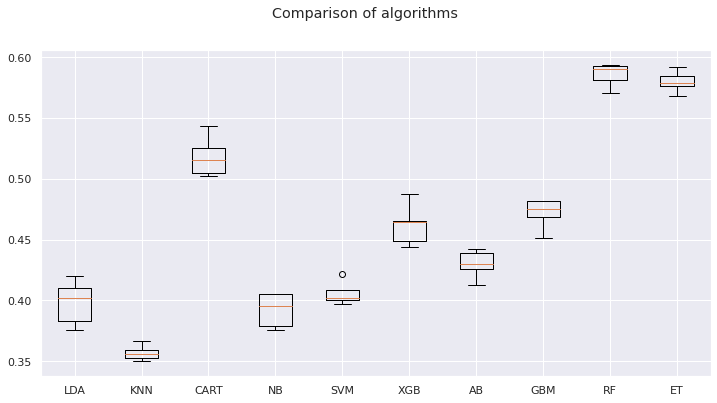

In [71]:
# compare algorithms boxplot
fig = plt.figure(figsize = [12,6])
fig.suptitle('Comparison of algorithms')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show();

#### Comments: 
The ensemble tree based algorithms RandomForest and ExtraTrees classifiers perform best. Since RandomForest has slightly better baseline accuracy, we will tune its parameters.

## Tune the best algorithm

Using RandomizedSearchCV method, we can define a grid of hyperparameter ranges, and randomly sample from the grid, performing K-Fold CV with each combination of values.

In [78]:
# create the random parameter grid to sample from during fitting
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],  # number of trees in forest
              'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)], # max no of levels in each tree
              'min_samples_leaf': [1, 2, 4], # min no of data points allowed in leaf node
               'min_samples_split': [2, 5, 10], # min no of data points placed in a node before split
               'max_features': ['auto', 'sqrt'] # max no of features considered for a splitting node
             }               
# create an instance of the classifier
model_RF = RandomForestClassifier(random_state = 42)

# random search of parameters using 5-fold cross validation
# search across 100 different combinations
# set n_jobs = 1 to use only one processor at a time, to avoid memory leaks
RF_grid = RandomizedSearchCV(estimator = model_RF, 
                         param_distributions = random_grid,
                         n_iter = 100, cv = 5, verbose = 2, 
                         random_state = 42, n_jobs = 1)
                        
# fit the random search model
#RF_random = RF_grid.fit(X_train_prep, y_train)

# print the best score and the best parameters
#print("Best: %f using %s" % (RF_random.best_score_, RF_random.best_params_))

#means_RF = RF_random.cv_results_['mean_test_score']
#stds_RF = RF_random.cv_results_['std_test_score']
#params_RF = RF_random.cv_results_['params']

#for mean_RF, stdev_RF, param_RF in zip(means_RF, stds_RF, params_RF):
    #print("%f (%f) with: %r" % (mean_RF, stdev_RF, param_RF))
    
    

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   8.1s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   8.3s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   8.1s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   8.2s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   8.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time=   5.3s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time=   5.3s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_es

[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   7.7s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   7.5s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   7.4s
[CV] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   4.9s
[CV] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   4.8s
[CV] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   4.8s
[CV] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   4.8s
[CV] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   4.6s
[CV] END max_depth=90, max_

[CV] END max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1600; total time=   7.4s
[CV] END max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1600; total time=   7.6s
[CV] END max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1600; total time=   7.4s
[CV] END max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1600; total time=   7.5s
[CV] END max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1600; total time=   7.5s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=  10.6s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=  10.2s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=  10.4s
[CV] END max_depth=40, max_featu

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=   6.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=   6.9s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   7.4s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   7.5s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   7.4s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   7.5s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   7.4s
[CV] END max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   2.8s
[CV] END max_depth=110, max_fea

[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   3.0s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   3.0s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   3.2s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   3.2s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  10.0s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  10.1s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  10.0s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  10.1s
[CV] END max_depth=60, max_features=

[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   1.9s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   3.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   3.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   3.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   3.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   3.1s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   4.2s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   4.3s
[CV] END max_depth=60, max_features=sqrt

[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   1.9s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   1.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=   7.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=   8.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=   8.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=   8.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=   8.1s
[CV] END max_depth=30, max_featu

[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  11.1s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  11.1s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  10.6s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  10.7s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  11.1s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=   5.7s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=   5.7s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=   5.8s
[CV] END max_depth=100, ma

In [80]:
# print the parameters of the best estimator
#best_RF = RF_grid.best_estimator_
#best_RF

RandomForestClassifier(max_depth=90, min_samples_split=5, n_estimators=1400,
                       random_state=42)

In [81]:
# create an instance of the best model
RF_clf = RandomForestClassifier(n_estimators = 1400, 
                                min_samples_split = 5, 
                                min_samples_leaf = 1,
                                max_features = 'auto',
                                max_depth = 90,
                                random_state = 42)
# fit the classifier on the train set
RF_clf.fit(X_train_prep,y_train)
# predict on the test set
y_pred_RF = RF_clf.predict(X_test_prep)

# compute cv scores on the train set 
scores_train = cross_val_score(RF_clf, X_train_prep, y_train, cv=10)
scores_train.mean()

0.6122589531680441

In [83]:
# get the final model parameters
print('Final Model Parameters:\n')
RF_clf.get_params()

Final Model Parameters:



{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 90,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1400,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [84]:
# evaluate performance metrics on the train set
perf_train_RF = pd.Series(uf.get_perf_metrics(RF_clf.fit(X_train_prep,y_train),
                                              X_train_prep, y_train), 
                       index = lm.metrics_list)

# evaluate performance metrics on the test set
perf_test_RF = pd.Series(uf.get_perf_metrics(RF_clf.fit(X_train_prep,y_train),
                                             X_test_prep, y_test), 
                         index = lm.metrics_list)

# combine performance metrics for the baseline model
perf_model_RF = pd.DataFrame.from_dict({'train': perf_train_RF,
                                        'test': perf_test_RF}).round(3)

In [85]:
# print evaluation metrics and results

print('Performance metrics comparison for RandomForestClassifier:\n', perf_model_RF)

result1_RF = confusion_matrix(y_test, y_pred_RF)
print('\nRandomForestClassifier Confusion Matrix for Test Set:')
print(result1_RF)

result2_RF = classification_report(y_test, y_pred_RF)
print('\nRandomForestClassifier Classification Report for Test Set:')
print (result2_RF)

Performance metrics comparison for RandomForestClassifier:
            train   test
accuracy   0.996  0.625
precision  0.998  0.737
recall     0.992  0.540
f1         0.995  0.585

RandomForestClassifier Confusion Matrix for Test Set:
[[ 98  30   3  44  83]
 [  4 229   7 172  74]
 [  2  21 141 143  76]
 [  2  32   3 621 263]
 [  2  14   1 190 857]]

RandomForestClassifier Classification Report for Test Set:
              precision    recall  f1-score   support

           1       0.91      0.38      0.54       258
           2       0.70      0.47      0.56       486
           3       0.91      0.37      0.52       383
           4       0.53      0.67      0.59       921
           5       0.63      0.81      0.71      1064

    accuracy                           0.63      3112
   macro avg       0.74      0.54      0.59      3112
weighted avg       0.67      0.63      0.62      3112



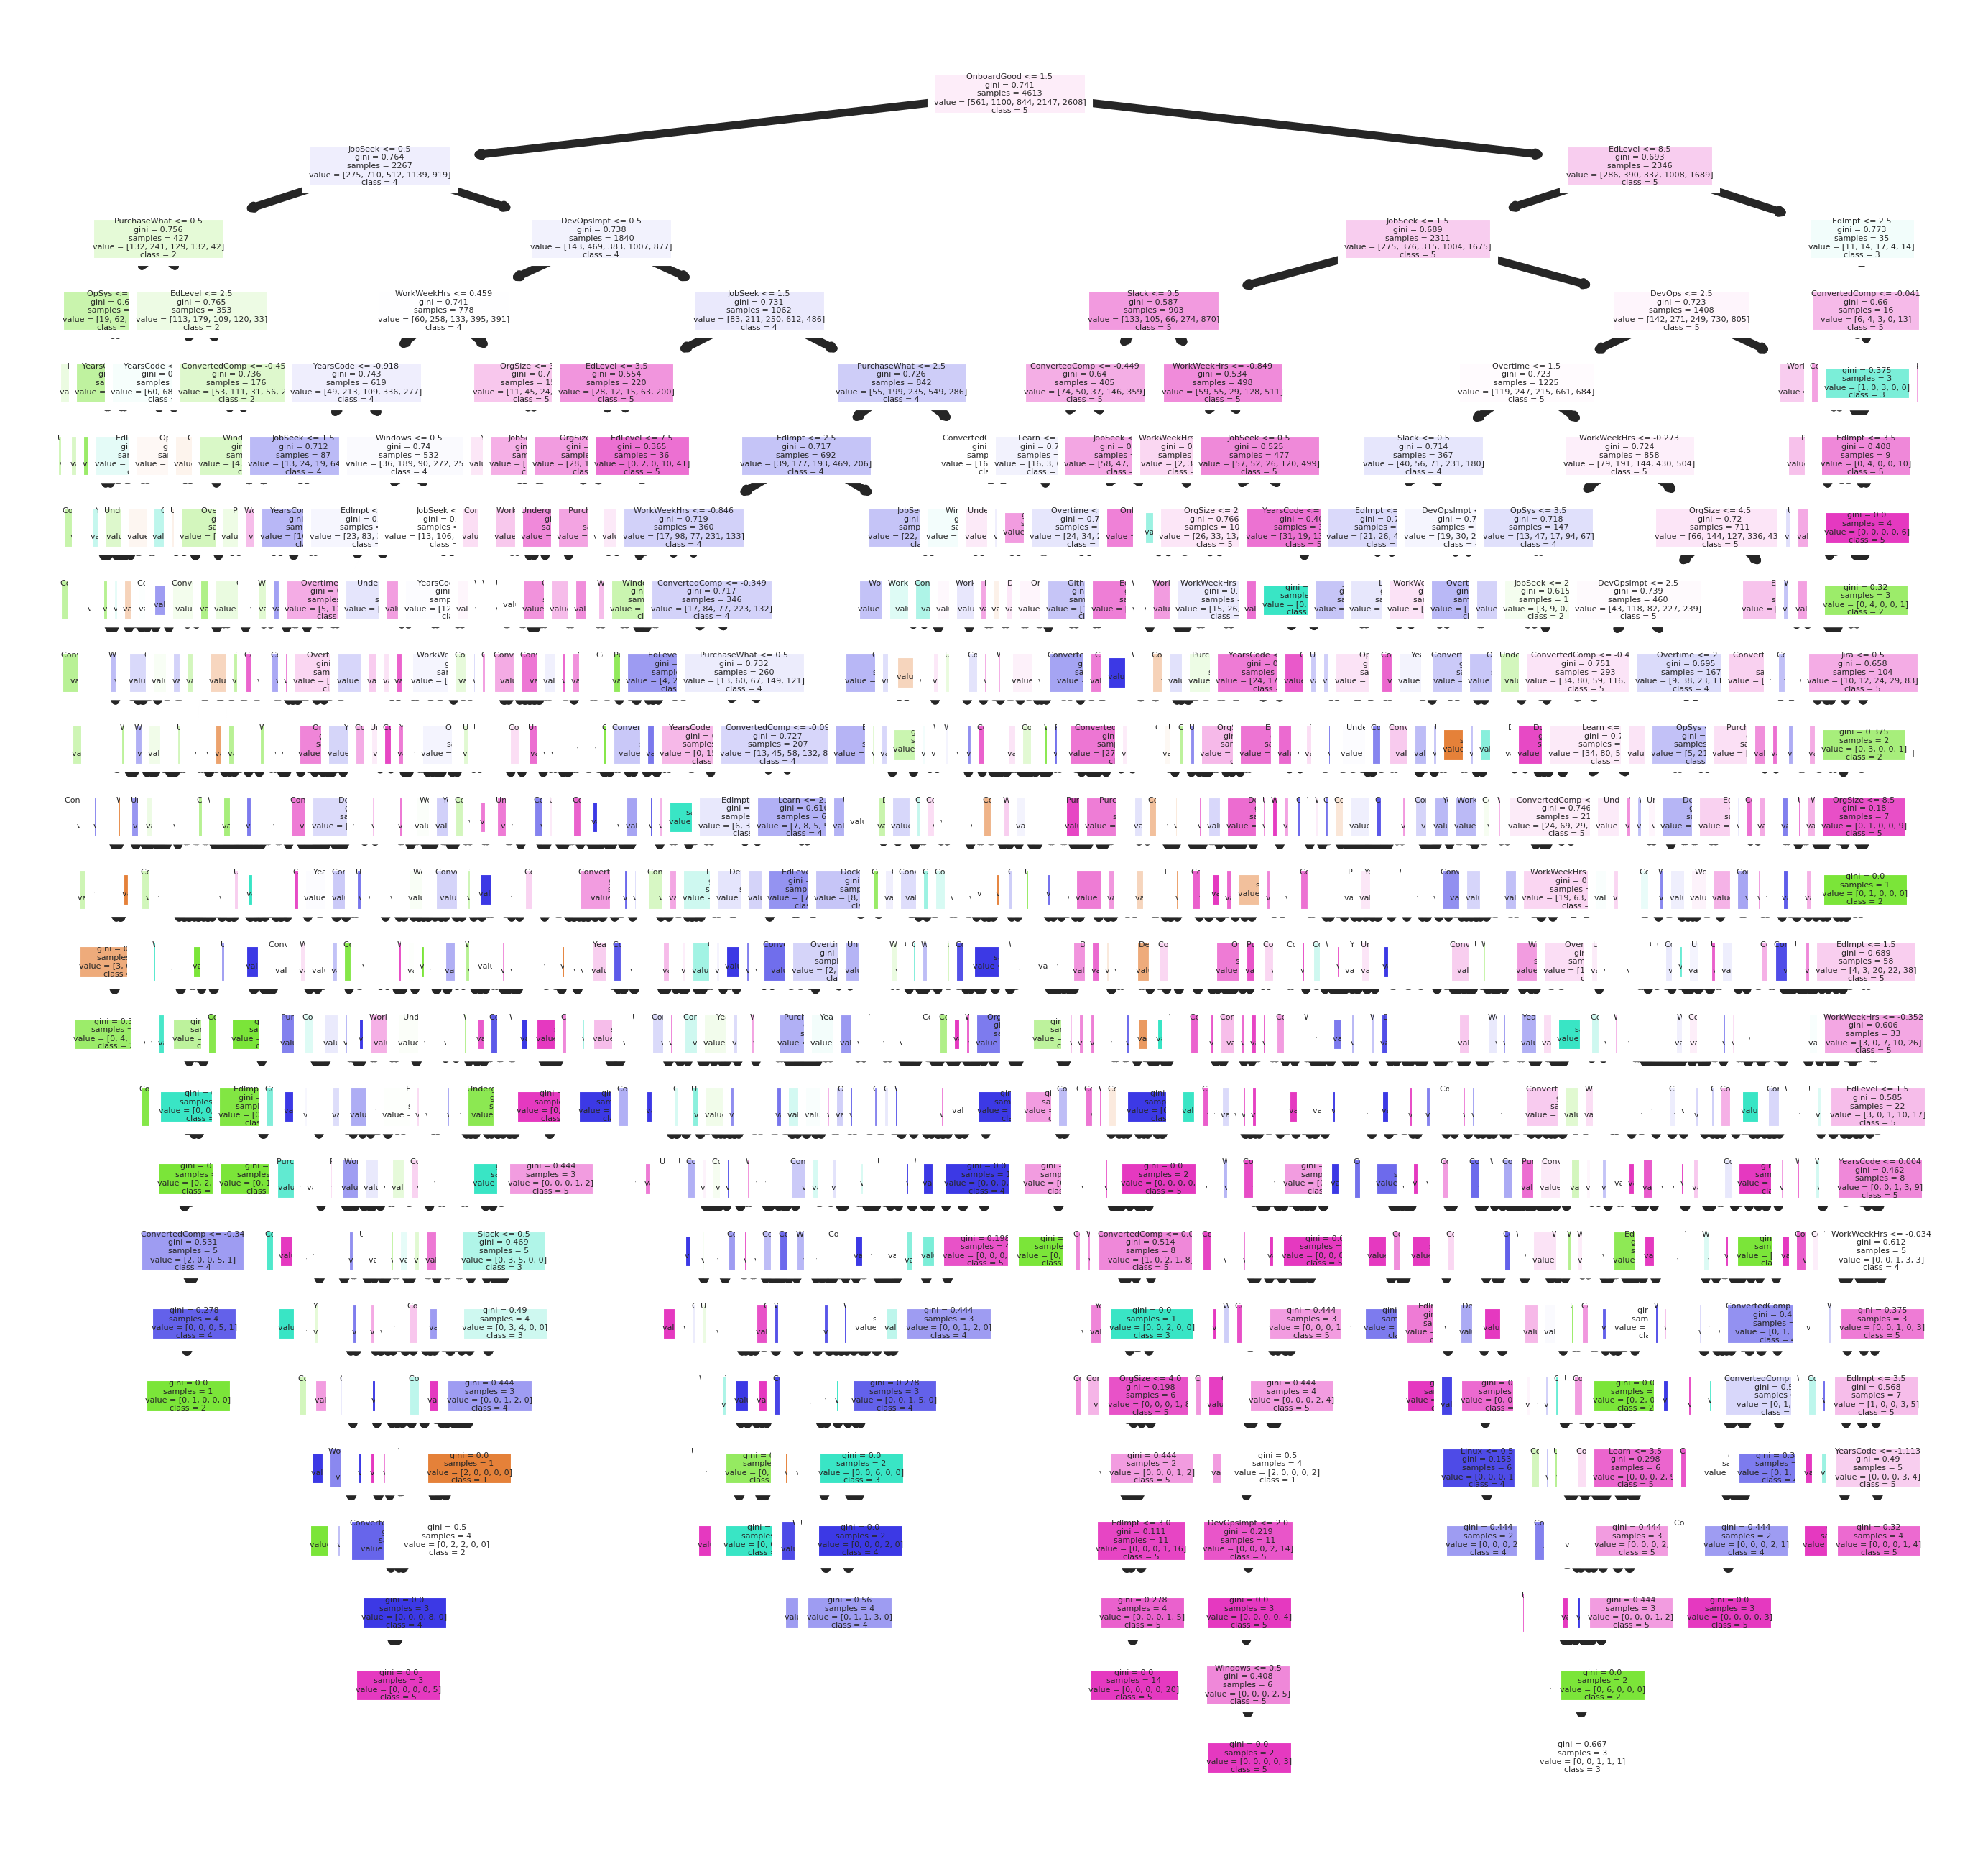

In [118]:
# visualize one of the decision trees and save image to a file
fn = X_train_prep.columns
cn = ['1','2','3','4','5']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(RF_clf.estimators_[1],
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig(mypath + 'data/interim/visual_tree.png')

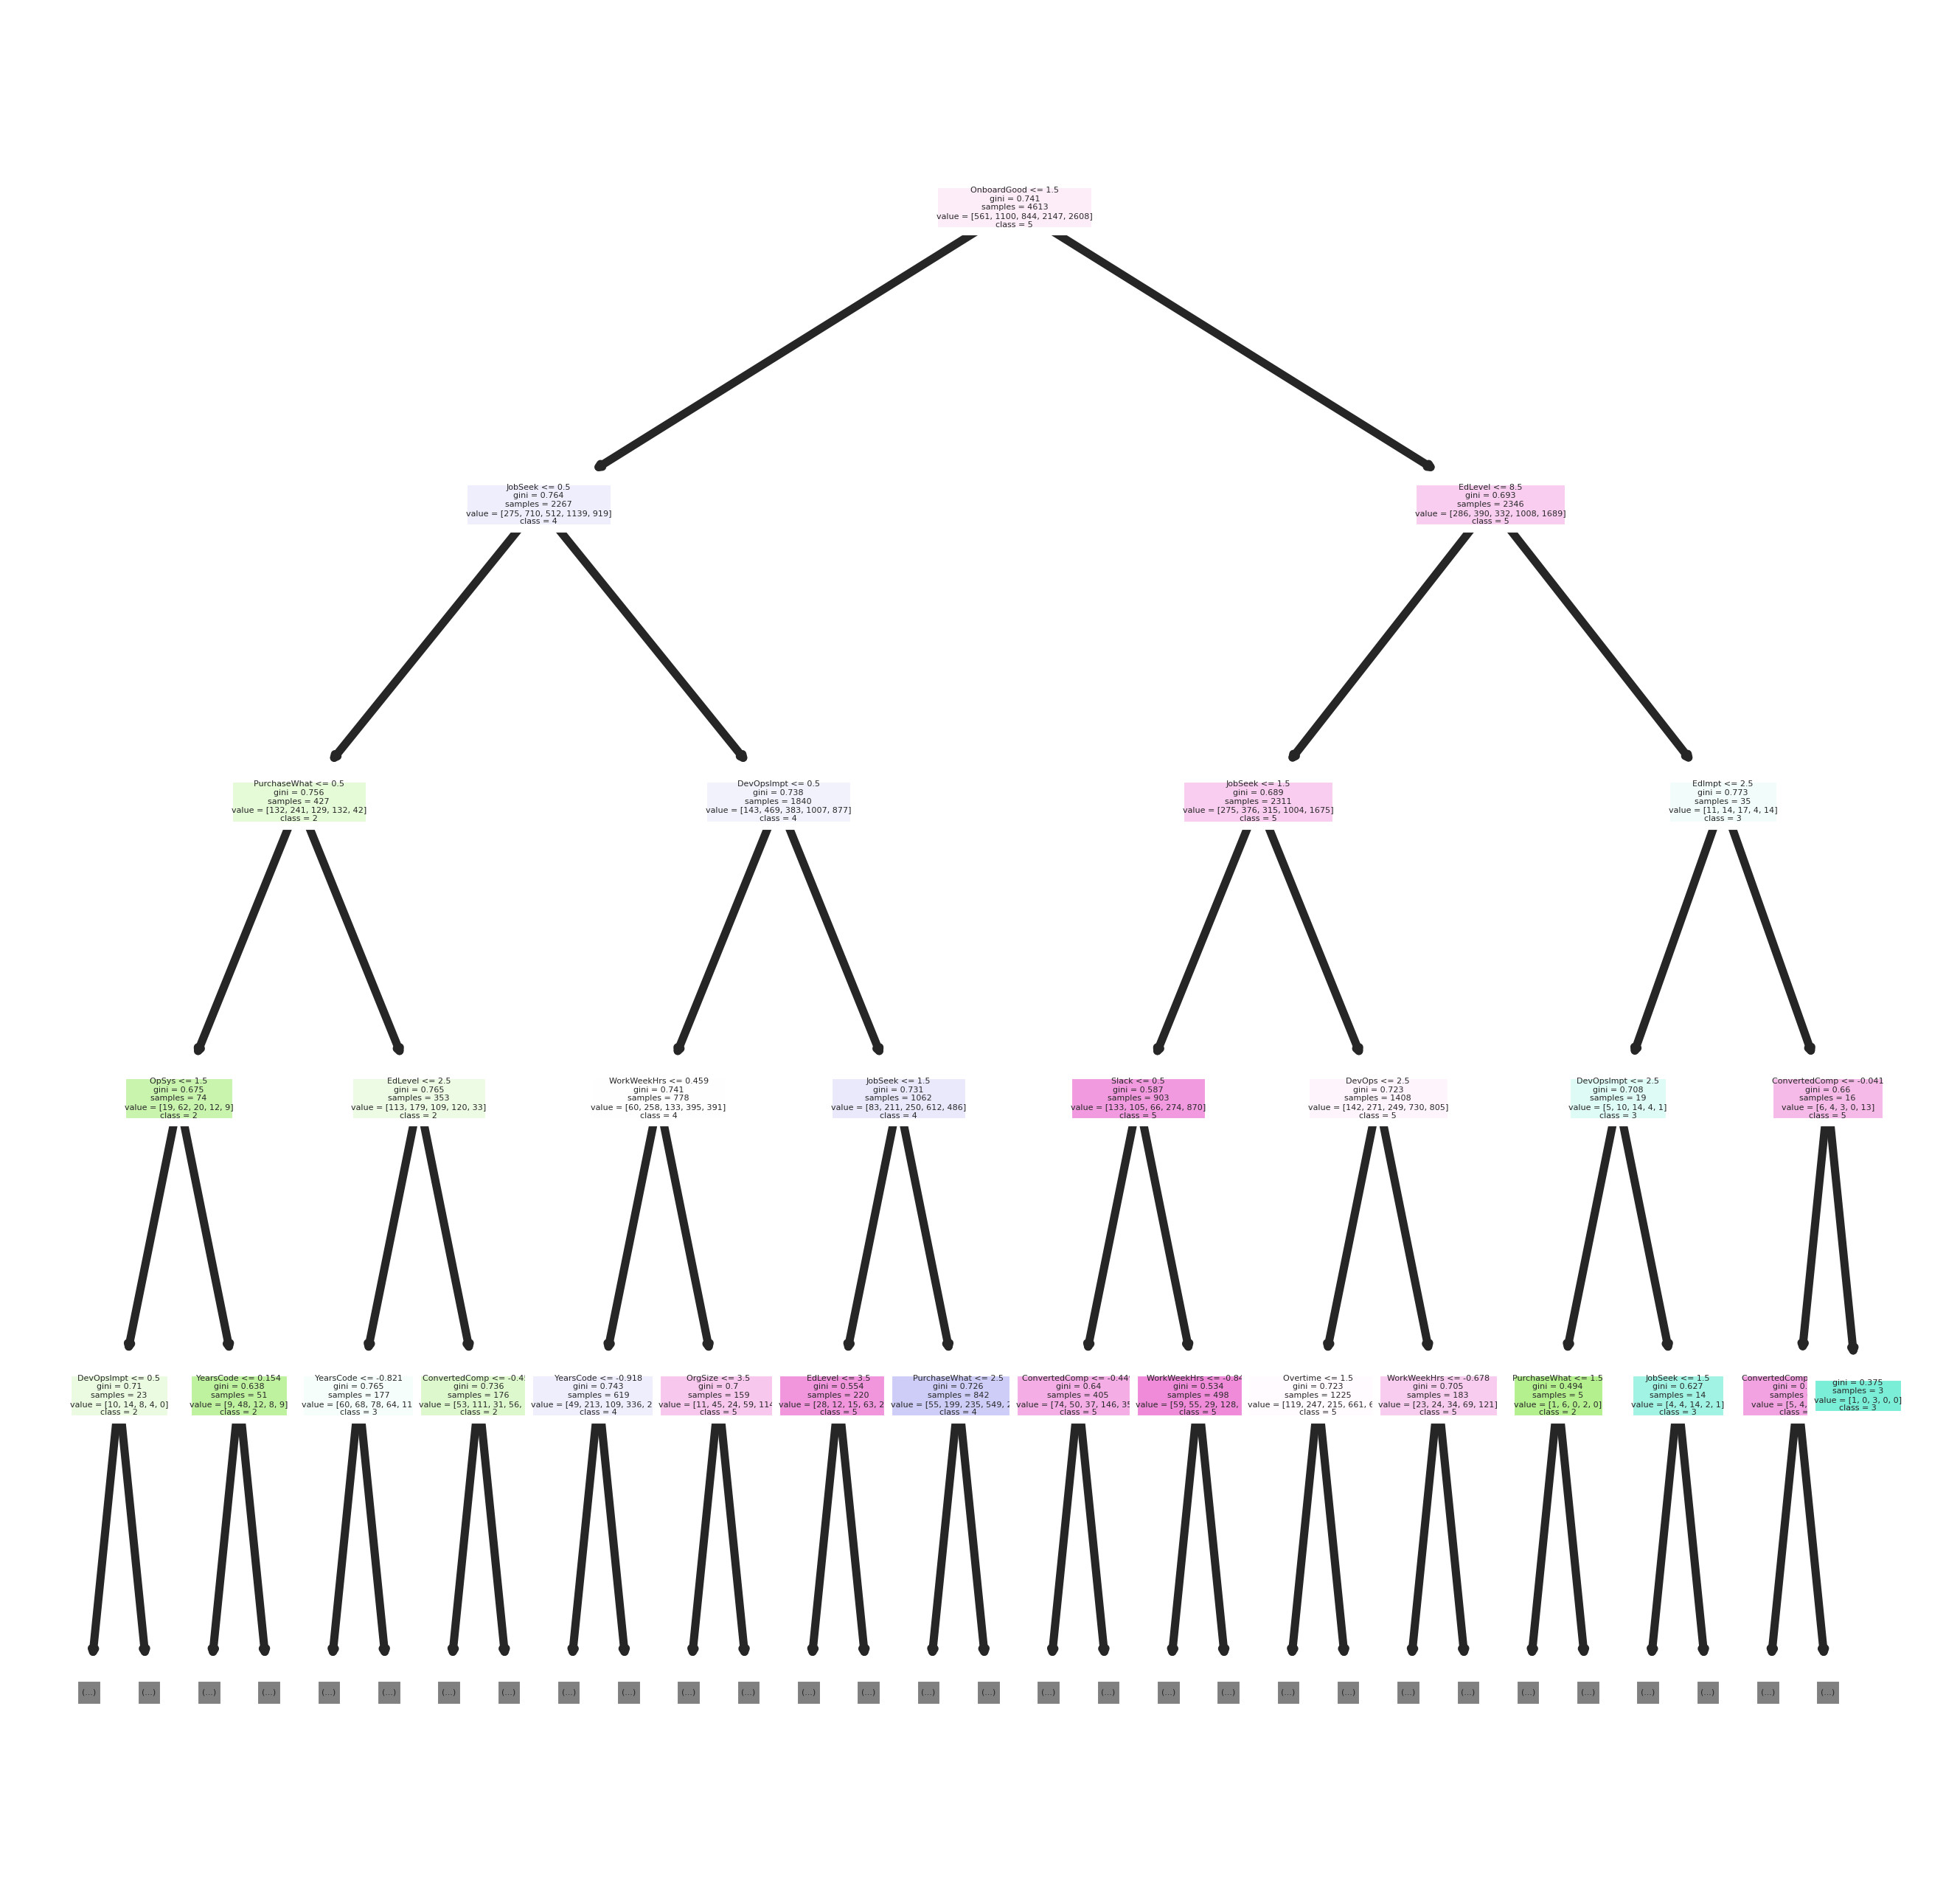

In [130]:
# visualize the tree up to depth 4
fn = X_train_prep.columns
cn = ['1','2','3','4','5']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(RF_clf.estimators_[1], max_depth = 4,
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig(mypath + 'data/interim/visual_tree_reduced.png')

## Interpret results with SHAP

In [119]:
# import the package
import shap
# create the explainer
explainer = shap.TreeExplainer(RF_clf)

In [121]:
choosen_instance = X_test_prep.iloc[421]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [124]:
shap.summary_plot(shap_values, X_train_prep)

IndexError: tuple index out of range